<a href="https://colab.research.google.com/github/ponOlgap/OLga/blob/main/urfu_dl_yelp_polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка своего набора данных для анализа текста на примере отзывов [YELP](https://www.yelp.com/dataset)

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Среда выполнения -> Сменить среду выполнение -> Аппаратный ускоритель -> GPU).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
num_words = 10000
max_review_len = 100

## Загрузка набора данных

In [ ]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2023-05-13 11:47:40--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2023-05-13 11:47:40--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc51cb37375345b9a02966b9e817.dl.dropboxusercontent.com/cd/0/get/B78jLl0dDzOH-MjStZEg7MpuKW-1p0zP0TQasHzZtWavTNrWoEHdh4vMgICKarYQj26-Vm_mR5XQ6QRP3NhM3Z8SXVW8VJ9f13rNNRpl5Jw-mmHlvK7Qtpt3yAiWXeDQZVIBpY0F7YJbL5QD5xrLsfinTEq8wefTy9iZbObnoCEb-Q/file?dl=1# [following]
--2023-05-13 11:47:41--  https://uc51cb37375345b9a02966b9e817.dl.dropboxusercontent.com/cd/0/get/B78jLl0dDzOH-MjStZEg7MpuKW-1p0

In [ ]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


## Просматриваем данные

In [ ]:
!head yelp_review_polarity_csv/train.csv

"1","Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
"2","Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. H

In [ ]:
!head yelp_review_polarity_csv/test.csv

"2","Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
"1","Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the same issue. I called to complain, and the \""manager\"" didn't even apolog

In [ ]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv',
                    header=None,
                    names=['Class', 'Review'])

In [ ]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


Выделяем данные для обучения

In [ ]:
reviews = train['Review']

In [ ]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Выделяем правильные ответы

In [ ]:
y_train = train['Class'] - 1

In [ ]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

## Токенизация текста

In [ ]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на отзывах Yelp

In [ ]:
tokenizer.fit_on_texts(reviews)

Просматриваем словарь токенизатора

In [ ]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'was': 6,
 'of': 7,
 'it': 8,
 'for': 9,
 'in': 10,
 'is': 11,
 'n': 12,
 'that': 13,
 'my': 14,
 'we': 15,
 'this': 16,
 'but': 17,
 'with': 18,
 'they': 19,
 'you': 20,
 'on': 21,
 'not': 22,
 'have': 23,
 'had': 24,
 'at': 25,
 'were': 26,
 'so': 27,
 'are': 28,
 'food': 29,
 'be': 30,
 'place': 31,
 'me': 32,
 'there': 33,
 'good': 34,
 'as': 35,
 'out': 36,
 'all': 37,
 'like': 38,
 'if': 39,
 'just': 40,
 'our': 41,
 'very': 42,
 'get': 43,
 'one': 44,
 'here': 45,
 'time': 46,
 'when': 47,
 'up': 48,
 'or': 49,
 'from': 50,
 'great': 51,
 'service': 52,
 'would': 53,
 'back': 54,
 'their': 55,
 'about': 56,
 'no': 57,
 'go': 58,
 'an': 59,
 'what': 60,
 'really': 61,
 'he': 62,
 "it's": 63,
 'she': 64,
 'which': 65,
 'will': 66,
 'some': 67,
 'only': 68,
 'been': 69,
 'us': 70,
 'your': 71,
 'because': 72,
 'more': 73,
 'even': 74,
 'can': 75,
 'them': 76,
 'by': 77,
 "don't": 78,
 'got': 79,
 'other': 80,
 'after': 81,
 'do': 8

Преобразуем отзывы Yelp в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)

Просматриваем отзывы в числовом представлении

In [ ]:
index = 2
print(reviews[index])
print(sequences[index])

I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need

In [ ]:
tokenizer.word_index['what']

60

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [ ]:
x_train[:5]

array([[   7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,   10,
        2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,  803,
          88, 3812,    1,  446,    8,  392,  841,  115,  360,    7, 4136,
        1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,   49,
        1687,    4,  418,   18,    8,    3,   23,  563,  178,   16,  460,
          18,  189,   80, 3128,    2,    3,   40,   78,   43,    8,   20,
          23,  644, 1343,   20,   23, 3252,   18, 2921,  637,  227,  430,
         476, 4312,    1,  446,   63,    2,   22,  215,    1,   63,   18,
        2269,   13,    3,  249,   13,    3,   23,    4,  163,  939,  115,
         237],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   69,  116,
           4,  939,    9,   94,  201,  274,    3,  142,    3,    6,   44,
           7,  177, 2084, 3252,   47,   62,  422,   25, 1334,   69,   51,
          94,    1,  274,    2,   11,   61,   37,   56,    1,  219, 1403,
           8,   11,   7

## Создаем нейронную сеть

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/5
3938/3938 [==============================] - 98s 23ms/step - loss: 0.2323 - accuracy: 0.9066 - val_loss: 0.1734 - val_accuracy: 0.9329
Epoch 2/5
3938/3938 [==============================] - 26s 7ms/step - loss: 0.1809 - accuracy: 0.9302 - val_loss: 0.1920 - val_accuracy: 0.9293
Epoch 3/5
3938/3938 [==============================] - 20s 5ms/step - loss: 0.1110 - accuracy: 0.9587 - val_loss: 0.2391 - val_accuracy: 0.9167
Epoch 4/5
3938/3938 [==============================] - 19s 5ms/step - loss: 0.0594 - accuracy: 0.9785 - val_loss: 0.3311 - val_accuracy: 0.9149
Epoch 5/5
3938/3938 [==============================] - 18s 5ms/step - loss: 0.0394 - accuracy: 0.9858 - val_loss: 0.4082 - val_accuracy: 0.9104


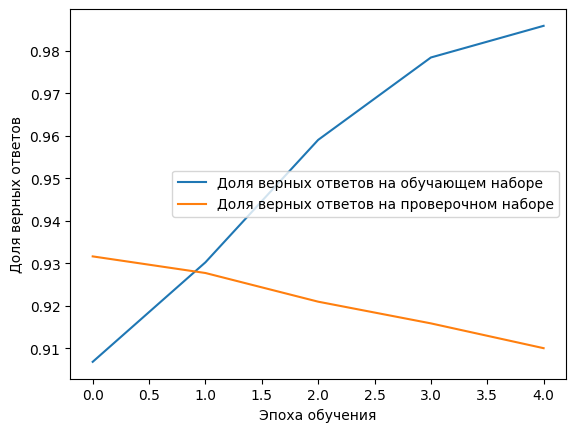

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv',
                    header=None,
                    names=['Class', 'Review'])

In [ ]:
test

,Class,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...
...,...,...
37995,1,If I could give 0...I would. Don't do it.
37996,2,Items Selected:\nChocolate Cinnamon Horn\nSmal...
37997,1,Expensive lunch meals. Fried pickles were goo...
37998,1,Highly overpriced and food was cold. Our waitr...


Преобразуем отзывы в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [ ]:
x_test[:5]

array([[   9,    1,  546,  148,  274,  165,    2, 1221,    4,   14,  137,
          18,  289,   38, 8346, 2311,  257,  511,   28, 1167,    2,  113,
          60,  568,  520, 1426,   16,   11,   44,   31,   13,    3,   82,
          22,  249,   38,    3,  144,  173,  694, 2235,    7,   40,   72,
           7,   14,   80, 2540, 5951,   23,   69,    9,   21,   14,    7,
        1558,    2,   23, 1696,   14, 1894, 1775,  470,   17,   45,   14,
          52,    2, 1346, 5923,   95,   37,   69,   91, 1024,    2,  311,
          48,    4,   32,    4, 1480, 1037,   19,   40, 4124,    1,  317,
         127,    8,  562,    5,  203,  114,   99,    8,   90,   10, 1168,
         274],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  182, 1243,    3,   24,
          59,  728,    4,   43,  159, 2073,    2,   24,    4,  154,    5,
         315,  190,   4

Правильные ответы

In [ ]:
y_test = test['Class'] - 1

In [ ]:
y_test

0        1
1        0
2        1
3        0
4        1
        ..
37995    0
37996    1
37997    0
37998    0
37999    0
Name: Class, Length: 38000, dtype: int64

## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 3s 2ms/step - loss: 0.4575 - accuracy: 0.8961


[0.45748060941696167, 0.8961052894592285]

## Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place.
The food is really bad and very expensive.  The host and waiters are rude.
I will never visit the SmartBurger again!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
sequence

[[1,
  104,
  11,
  692,
  5,
  197,
  5272,
  31,
  1,
  29,
  11,
  61,
  143,
  2,
  42,
  502,
  1,
  1526,
  2,
  1713,
  28,
  401,
  3,
  66,
  88,
  285,
  1,
  108]]

In [ ]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [ ]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,  104,   11,  692,    5,
         197, 5272,   31,    1,   29,   11,   61,  143,    2,   42,  502,
           1, 1526,    2, 1713,   28,  401,    3,   66,   88,  285,    1,
         108]], dtype=int32)

In [ ]:
result = model.predict(data)

1/1 [==============================] - 0s 21ms/step


In [ ]:
result

array([[0.00042698]], dtype=float32)

In [ ]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')


Отзыв отрицательный
